In [1]:
import pandas as pd

sales_long = pd.read_parquet("data/sales_long.parquet")

In [2]:
sales_long.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,...,is_weekend,is_holiday,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,price_lag_7,price_change
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,8.26,0.0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.97,0.0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,4.64,0.0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.98,0.0


In [3]:
# Select features and target variable
features = ["lag_7", "lag_14", "lag_28", 
            "rolling_mean_7", "rolling_mean_14", "rolling_mean_28", 
            "day_of_week", "month", "is_weekend", "is_holiday",
            "sell_price", "price_change"]

X_train = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1, 1914)])][features]
y_train = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1, 1914)])]["sales"]

X_val = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1914, 1942)])][features]
y_val = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1914, 1942)])]["sales"]


In [4]:
sales_long["d"].value_counts()

d
d_1       30490
d_1324    30490
d_1322    30490
d_1321    30490
d_1320    30490
          ...  
d_653     30490
d_652     30490
d_651     30490
d_650     30490
d_1969    30490
Name: count, Length: 1969, dtype: int64

In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score

# Train an XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, colsample_bytree=0.5 ,max_depth=10, tree_method="hist", device="cuda", missing=-999)
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {mae:.2f}")

r2 = r2_score(y_val, y_pred)
print(f"Validation R² Score: {r2:.2f}")

Validation MAE: 1.02
Validation R² Score: 0.67


/home/andre/.local/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [18:58:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Lets apply shap to underestand the relevance of each feature in the tree

100%|===================| 853537/853720 [50:16<00:00]        

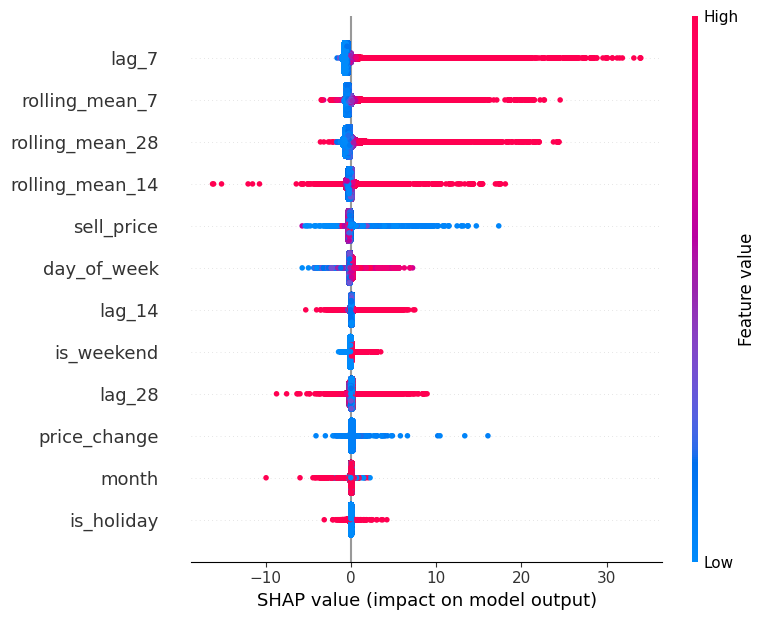

In [6]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the validation set
shap_values = explainer(X_val)

# Visualize Feature Importance
shap.summary_plot(shap_values, X_val)





Traing the model with shap cut

In [7]:
# Select features and target variable
features = ["lag_7", "rolling_mean_7", "rolling_mean_14", "rolling_mean_28", "day_of_week", "sell_price"]


X_train = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1, 1914)])][features]
y_train = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1, 1914)])]["sales"]

X_val = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1914, 1942)])][features]
y_val = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1914, 1942)])]["sales"]

In [8]:

model = XGBRegressor(n_estimators=100, learning_rate=0.1, colsample_bytree=0.5 ,max_depth=10, tree_method="hist", device="cuda", missing=-999)
model.fit(X_train, y_train)


# Validate the model
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {mae:.2f}")

r2 = r2_score(y_val, y_pred)
print(f"Validation R² Score: {r2:.2f}")

Validation MAE: 1.03
Validation R² Score: 0.67


This didnt give significant changes - lets try LGBMRegressor

In [9]:
#pip install lightgbm[gpu]

In [10]:
# Import necessary libraries
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize and train the LightGBM model
lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
lgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lgb = lgb_model.predict(X_val)

# Evaluate the model's performance
mae = mean_absolute_error(y_val, y_pred_lgb)
print(f"Validation MAE: {mae:.2f}")

r2 = r2_score(y_val, y_pred_lgb)
print(f"Validation R² Score: {r2:.2f}")


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 6
[LightGBM] [Info] Start training from score 1.126322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation MAE: 1.03
Validation R² Score: 0.68


Without significant differeces again